<a href="https://colab.research.google.com/github/Mpkosh/masters_pmda_finproject/blob/main/Koshkareva_FinProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Индивидуальный проект**

In [ ]:
#@title Загружаем библиотеки
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest,f_classif,SelectPercentile, f_regression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import Normalizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.linear_model import LogisticRegression

In [ ]:
#@title Загружаем данные
%%capture
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/master/pt/data/train_v2.csv') as file:
    df = pd.read_csv(file) 

drive.flush_and_unmount()



*This competition asks you to determine whether a loan will default, as well as the loss incurred if it does default. Unlike traditional finance-based approaches to this problem, where one distinguishes between good or bad counterparties in a binary way, we seek to anticipate and incorporate both the default and the severity of the losses that result. In doing so, we are building a bridge between traditional banking, where we are looking at reducing the consumption of economic capital, to an asset-management perspective, where we optimize on the risk to the financial investor.*

Было выдвинуто две задачи, из которых я выбрала первую:
*   Прогнозирование дефолта по кредиту $\checkmark$
*   Потери в случае наступления дефолта

(https://www.kaggle.com/c/loan-default-prediction/overview)

Для начала посмотрим на датасет.

In [ ]:
df.shape

(105471, 771)

In [ ]:
df.head(5)

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,...,f740,f741,f742,f743,f744,f745,f746,f747,f748,f749,f750,f751,f752,f753,f754,f755,f756,f757,f758,f759,f760,f761,f762,f763,f764,f765,f766,f767,f768,f769,f770,f771,f772,f773,f774,f775,f776,f777,f778,loss
0,1,126,10,0.686842,1100,3,13699,7201.0,4949.0,126.75,126.03,7,0.7607,0.7542,612922,0.7236,0.7236,0.5171,0.7236,0.8476,0.7876,1.097851e+09,89,66,998046.0,89.0,89.0,89.00,89.00,89.0,0.9271,0,0,0,5,0,0,0.73180,0.72124,0.749280,...,-4.40,6,9.76,-21.82,49.18,1.0435,-0.9066,1.5883,3.4154,2.8283,2.3451,0.030594,1.7418,1.5271,0.8474,0.4715,0.028362,3.1611,2.5162,2.0037,0.019636,4.4352,4.2676,-0.1524,1,-0.40,-0.560,-0.440,-0.6280,-3.14,5,2.14,-1.54,1.18,0.1833,0.7873,1,0,5,0
1,2,121,10,0.782776,1100,3,84645,240.0,1625.0,123.52,121.35,7,0.6555,0.6555,245815,0.6341,0.6341,0.3909,0.6667,0.6903,0.6903,8.449459e+08,78,50,754416.0,78.0,78.0,78.00,78.00,78.0,0.8478,0,0,0,6,0,0,0.65705,0.64069,0.626200,...,0.35,7,51.73,-72.44,798.74,2.7180,-0.8294,1.0740,2.9194,2.1180,1.5666,0.120442,1.1963,1.0322,0.4843,0.2389,0.130160,2.7659,1.9523,1.4059,0.115277,3.2763,2.7962,-0.3097,1,-0.17,-0.275,-0.203,-0.2300,-1.38,6,0.54,-0.24,0.13,0.1926,-0.6787,1,0,5,0
2,3,126,10,0.500080,1100,3,83607,1800.0,1527.0,127.76,126.49,7,0.7542,0.7542,1385872,0.7542,0.7542,0.5508,0.7542,0.8091,0.7807,1.308478e+09,89,54,1037651.0,89.0,89.0,100.43,94.37,89.0,0.9175,0,0,0,13,0,0,0.74710,0.75878,0.654685,...,-6.35,14,56.62,-79.48,621.97,1.9592,-0.3632,3.2969,7.2072,5.7062,4.5627,0.226336,3.3277,3.4166,1.8321,0.9979,0.103307,6.8623,5.2963,4.1282,0.219729,8.1381,7.3269,-0.1909,1,-0.58,-0.540,-0.572,-0.3985,-5.18,13,2.89,-1.73,1.04,0.2521,0.7258,1,0,5,0
3,4,134,10,0.439874,1100,3,82642,7542.0,1730.0,132.94,133.58,7,0.8017,0.7881,704687,0.7881,0.7881,0.5923,0.7881,0.8230,0.8158,1.472752e+09,93,55,1115721.0,93.0,93.0,114.63,102.92,93.0,0.9688,0,0,0,4,0,0,0.77405,0.78929,0.750675,...,3.75,5,36.31,18.15,429.81,2.5883,-0.8812,1.2950,2.5777,2.0830,1.6899,0.054630,1.3748,1.3421,0.7982,0.4810,0.081205,2.5571,2.0593,1.6653,0.056470,3.2516,3.0631,-0.1770,1,-0.75,-0.635,-0.745,-0.5100,-2.04,4,1.29,-0.89,0.66,0.2498,0.7119,1,0,5,0
4,5,109,9,0.502749,2900,4,79124,89.0,491.0,122.72,112.77,6,0.5263,0.5263,51985,0.5263,0.5263,0.3044,0.5405,0.5556,0.5455,1.442916e+09,60,21,536400.0,60.0,60.0,60.00,60.00,60.0,0.8451,0,0,0,26,0,0,0.60315,0.53367,0.696150,...,11.45,27,2206.14,-10559.05,708436.49,9.0293,-0.8760,6.3852,17.2599,14.2795,11.9179,0.085330,7.2175,6.2262,3.1446,1.6149,0.074286,15.9080,12.5688,9.9844,0.067540,17.5561,15.6079,-0.4444,1,-0.18,-0.280,-0.182,-0.4277,-11.12,26,6.11,-3.82,2.51,0.2282,-0.5399,0,0,5,0


Посмотрим на целевую переменную. Как видно, очень много (около **90%**) данных -- значения "0".


In [ ]:
df.loss.value_counts().nlargest(15)

0     95688
2      1297
1      1145
3      1086
4      1038
5       685
6       573
7       565
8       487
10      316
9       312
11      234
12      211
13      188
14      157
Name: loss, dtype: int64

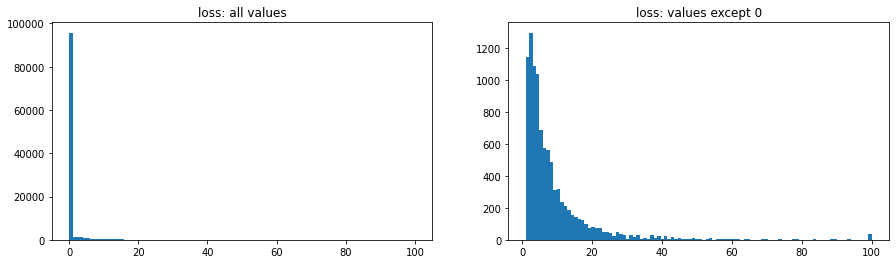

In [ ]:
plt.rcParams["figure.figsize"] = (15,4)
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(df.loss,bins=100)
ax1.title.set_text('loss: all values')
ax2.hist(df.loss[df.loss!=0],bins=100);
ax2.title.set_text('loss: values except 0')


Получается несбалансированный датасет. Хотя в очень многих задачах бинарной классификации (fraud detection и т.д.) похожие ситуации, когда один класс преобладает над вторым.

С этим можно справиться с помощью -- среди прочих методов -- undersampling`ом: убрать записи из самого многочисленного класса, чтобы свести соотношение двух классов поближе к 1:1.

Для начала попробуем проделать классификацию на изначальных данных

# Missing values

Также еще одна проблема -- пропущенные значения.
В основном, есть два способа борьбы с подобным ненастьем: удалить или дополнить.

Мы либо удаляем строки\столбцы с пропущенными данными, либо заменяем пропущенные значения средним, модой и т.д.

Посмотрим на наши пропуски, около 18%:

In [ ]:
df.isna().sum().nlargest(15)

f662    18833
f663    18833
f159    18736
f160    18736
f169    18417
f170    18417
f618    18407
f619    18407
f330    18067
f331    18067
f179    17162
f180    17162
f422    14235
f653    13205
f189    12234
dtype: int64

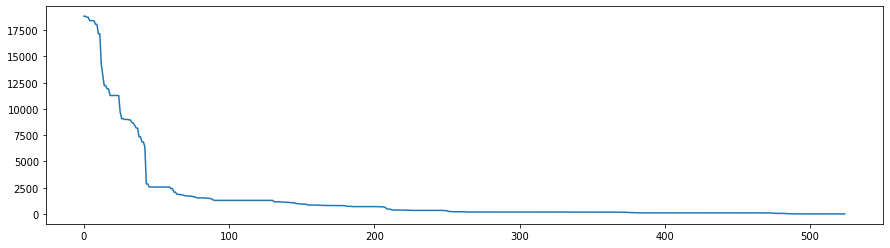

In [ ]:
clm_null = df.isna().sum()[df.isna().sum()>0]
plt.plot(np.sort(clm_null)[::-1])

Перед тем, как заменять значения, нужно посмотреть, если ли у нас категориальные величины. Предположим, что там меньше 6 категорий.

In [ ]:
df_null = df.loc[:,clm_null.index]
df_null.nunique()[df_null.nunique()<=5]

f678    1
dtype: int64

Только константа. Она не пострадает при нашем преобразовании + позже мы уберем признаки с одним и тем же значением

Заменим пропущенные данные медианой

In [ ]:
df.fillna(df.median(), inplace=True)
df.shape

(105471, 771)

In [ ]:
df.isna().sum().nlargest(5)

f137    177
id        0
f1        0
f2        0
f3        0
dtype: int64

Остался только один признак с крайне малым кол-м пропущенных значений. Просто удалим строки

In [ ]:
df.dropna(axis=0,inplace=True)
df.shape

(105294, 771)

От 105 471 строк осталось 105 294. Ничего не пострадало

Теперь наведем порядок в оставшихся данных

Удалим все признаки с одинаковыми значениями, так как они погоды нам не сделают

In [ ]:
const_clm = df.columns[df.nunique() <= 1]
const_clm

Index(['f33', 'f34', 'f35', 'f37', 'f38', 'f678', 'f700', 'f701', 'f702',
       'f736', 'f764'],
      dtype='object')

In [ ]:
df.drop(const_clm,axis=1,inplace=True)
df.shape

(105294, 760)

В колонках типа object с числами были записаны строки NA. Избавимся от них

In [ ]:
idx = df['f137'][df['f137']=='NA'].index

In [ ]:
df['f137'].loc[idx] = '0'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df['f137'].loc[idx]

83843    0
91200    0
91850    0
91851    0
91912    0
Name: f137, dtype: object

# Target

Так как у нас задача классификации, то преобразуем целевую переменную

In [ ]:
df.loss.value_counts()

0     95517
2      1297
1      1145
3      1085
4      1038
      ...  
92        1
77        1
85        1
80        1
63        1
Name: loss, Length: 89, dtype: int64

Добавим признак **loan_status**, который показывает, был ли дефолт по кредиту или нет.

In [ ]:
df['loan_status'] = np.where(df['loss'] > 0, 1, 0)
df.head(2)

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f36,f39,f40,f41,f42,f43,f44,f45,f46,...,f740,f741,f742,f743,f744,f745,f746,f747,f748,f749,f750,f751,f752,f753,f754,f755,f756,f757,f758,f759,f760,f761,f762,f763,f765,f766,f767,f768,f769,f770,f771,f772,f773,f774,f775,f776,f777,f778,loss,loan_status
0,1,126,10,0.686842,1100,3,13699,7201.0,4949.0,126.75,126.03,7,0.7607,0.7542,612922,0.7236,0.7236,0.5171,0.7236,0.8476,0.7876,1.097851e+09,89,66,998046.0,89.0,89.0,89.0,89.0,89.0,0.9271,5,0.73180,0.72124,0.74928,5.0,0.026826,1.037424,0.83380,0.84284,...,-4.40,6,9.76,-21.82,49.18,1.0435,-0.9066,1.5883,3.4154,2.8283,2.3451,0.030594,1.7418,1.5271,0.8474,0.4715,0.028362,3.1611,2.5162,2.0037,0.019636,4.4352,4.2676,-0.1524,-0.40,-0.560,-0.440,-0.628,-3.14,5,2.14,-1.54,1.18,0.1833,0.7873,1,0,5,0,0
1,2,121,10,0.782776,1100,3,84645,240.0,1625.0,123.52,121.35,7,0.6555,0.6555,245815,0.6341,0.6341,0.3909,0.6667,0.6903,0.6903,8.449459e+08,78,50,754416.0,78.0,78.0,78.0,78.0,78.0,0.8478,6,0.65705,0.64069,0.62620,6.0,0.107658,-0.915138,0.72515,0.70127,...,0.35,7,51.73,-72.44,798.74,2.7180,-0.8294,1.0740,2.9194,2.1180,1.5666,0.120442,1.1963,1.0322,0.4843,0.2389,0.130160,2.7659,1.9523,1.4059,0.115277,3.2763,2.7962,-0.3097,-0.17,-0.275,-0.203,-0.230,-1.38,6,0.54,-0.24,0.13,0.1926,-0.6787,1,0,5,0,0


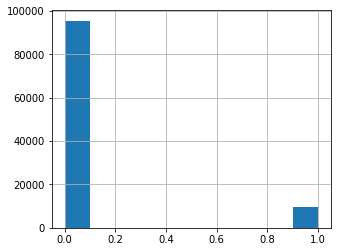

In [ ]:
plt.rcParams["figure.figsize"] = (5,4)
df.loan_status.hist()

In [ ]:
df.loan_status.value_counts(normalize=True)

0    0.907146
1    0.092854
Name: loan_status, dtype: float64

Как и упоминалось ранее, 90% -- первого класса

# Imbalanced classification

Будем работать с несбалансированным датасетом.

## Train-test

Для начала разобьем на обучающую и тестовую выборки.

Делаем это **перед** нормализаций, чтобы не было утечки данных:



*   Проходит подсчет минимумов и максимумов для каждого признака
*   Все данные нормализуются в зависимости от "глобального" min/max, например
*   После нормализации обучающая выборка "знает" данные о тестовой



In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1:-2],df.iloc[:,-1],test_size=0.3)

## Scaling

Можно использовать и стандартизацию, но в данном случае было принято решение сделать нормализацию. Единственное -- нормализация полезна, если данные не следуют нормальному распределению, тогда как стандартизация, наоборот, полезна при нормальном распределении

Используем нормализацию, чтобы все значения лежали в интервале [0;1]. Нормализация -- необходимый шаг для некоторых моделей машинного обучения. Поэтому лучше подготовим наши данные, чтобы они могли пройти через все терни

Если функция нормализации $y = \frac x z$, то $z$ равняется: 

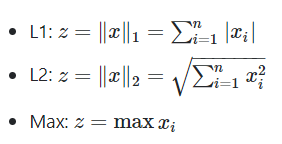

В нашем случае стандартный способ -- L1

In [ ]:
normalizer = Normalizer()
x_train = pd.DataFrame(normalizer.fit_transform(x_train),columns=x_train.columns)
x_test = pd.DataFrame(normalizer.transform(x_test),columns=x_train.columns)

Видим, что все данные нормализованы

In [ ]:
x_train.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f36,f39,f40,f41,f42,f43,f44,f45,f46,f47,...,f738,f739,f740,f741,f742,f743,f744,f745,f746,f747,f748,f749,f750,f751,f752,f753,f754,f755,f756,f757,f758,f759,f760,f761,f762,f763,f765,f766,f767,f768,f769,f770,f771,f772,f773,f774,f775,f776,f777,f778
0,7.060048e-36,5.786925e-37,2.660674e-38,7.523002e-35,9.259079e-37,4.752338e-33,4.454196e-34,2.224494e-34,6.980767e-36,7.053682e-36,6.944310e-37,4.748172e-38,4.708242e-38,8.736902e-32,4.708242e-38,4.708242e-38,3.425281e-38,4.708242e-38,4.873169e-38,4.873169e-38,8.518235e-29,5.555448e-36,3.240678e-36,6.453208e-32,5.555448e-36,5.555448e-36,6.847668e-36,6.148029e-36,5.555448e-36,5.727319e-38,4.629540e-37,4.321675e-38,4.642502e-38,3.758463e-38,4.629540e-37,5.076232e-39,4.798460e-38,4.635616e-38,4.848806e-38,4.083763e-38,...,2.807237e-37,2.076927e-38,1.869177e-37,5.208232e-37,7.874268e-36,-2.138847e-36,2.361094e-34,2.240524e-37,-4.076888e-38,9.189636e-38,2.346424e-37,1.715360e-37,1.275380e-37,5.441735e-39,1.003800e-37,7.579135e-38,3.414286e-38,1.633070e-38,6.293338e-39,2.300303e-37,1.659806e-37,1.215601e-37,5.065527e-39,2.961054e-37,2.626511e-37,-9.137554e-39,-4.513801e-38,-3.587893e-38,-4.351767e-38,-2.018479e-38,-1.614552e-37,4.629540e-37,9.027602e-38,-5.786925e-38,3.992978e-38,1.567678e-38,-3.843097e-38,0.000000e+00,0.0,2.968692e-35
1,2.121051e-37,3.366747e-39,7.085161e-40,2.188386e-36,6.733495e-39,1.055475e-36,1.774276e-36,1.021808e-35,2.165829e-37,2.127279e-37,2.525061e-38,1.654588e-39,1.640616e-39,1.962162e-32,1.640616e-39,1.640616e-39,1.524463e-39,1.654588e-39,1.654588e-39,1.640616e-39,3.790879e-30,1.935880e-37,1.919046e-37,2.871878e-33,1.935880e-37,1.935880e-37,1.935880e-37,1.935880e-37,1.935880e-37,1.654588e-39,4.040097e-38,1.527325e-39,1.611224e-39,1.482014e-39,4.040097e-38,7.970438e-41,1.127280e-39,1.567978e-39,1.640633e-39,1.532424e-39,...,-2.484660e-39,2.141925e-39,5.354812e-38,4.208434e-38,4.707891e-37,2.579333e-36,2.036679e-35,5.207012e-39,1.541129e-39,2.469476e-38,3.356546e-38,3.070979e-38,2.816537e-38,7.730894e-41,2.552163e-38,2.276797e-38,1.736686e-38,1.337828e-38,1.319563e-40,3.245242e-38,2.916697e-38,2.626164e-38,6.524588e-41,3.499549e-38,3.348870e-38,-2.878569e-41,-1.127860e-39,-9.847736e-40,-1.082409e-39,-1.043018e-39,-2.503177e-38,4.040097e-38,1.737242e-38,-1.292831e-38,9.898237e-39,3.614203e-40,1.196037e-39,1.683374e-39,0.0,3.366747e-39
2,5.413113e-36,4.093951e-37,3.439356e-38,8.187903e-35,7.278136e-37,3.633791e-33,1.356008e-34,1.113555e-34,5.572323e-36,5.444955e-36,2.274417e-37,3.678643e-38,3.584937e-38,9.170319e-32,3.584937e-38,3.584937e-38,2.631501e-38,3.615869e-38,3.710939e-38,3.710939e-38,6.543507e-29,4.230416e-36,3.229673e-36,4.957202e-32,4.230416e-36,4.230416e-36,4.774002e-36,4.485606e-36,4.230416e-36,4.316844e-38,9.097670e-38,3.657491e-38,3.590350e-38,3.662039e-38,9.097670e-38,7.812624e-40,-7.016168e-38,3.811469e-38,3.749241e-38,3.790772e-38,...,-1.911875e-37,-7.081171e-38,-2.124306e-37,1.364650e-37,9.921009e-37,-4.632988e-36,2.163562e-35,1.001426e-37,-4.052102e-38,3.831484e-38,6.320606e-38,5.272100e-38,4.399178e-38,7.578359e-40,3.831484e-38,3.323834e-38,2.014224e-38,1.222727e-38,1.164274e-39,6.207795e-38,5.129266e-38,4.238604e-38,3.939291e-40,8.166523e-38,7.881766e-38,-8.378954e-39,-3.411626e-38,-3.616324e-38,-3.434370e-38,-3.593580e-38,-7.187159e-38,9.097670e-38,5.686044e-38,-4.503347e-38,3.593580e-38,1.364650e-39,8.432630e-38,4.548835e-38,0.0,1.792241e-35
3,1.272081e-35,7.950507e-37,1.270527e-39,1.291957e-34,3.975253e-37,1.234416e-33,4.296255e-34,8.526918e-35,1.262143e-35,1.270093e-35,6.956693e-37,7.756713e-38,7.756713e-38,4.230584e-31,7.756713e-38,7.756713e-38,5.978781e-38,7.756713e-38,8.752514e-38,8.443438e-38,1.269435e-28,9.540608e-36,6.956693e-36,1.154032e-31,9.540608e-36,9.540608e-36,9.540608e-36,9.540608e-36,9.540608e-36,9.938133e-38,1.987627e-37,7.754228e-38,7.776092e-38,7.752738e-38,1.987627e-37,8.634548e-39,-7.859528e-38,8.550273e-38,8.672

## Feature selection

Т.к. в датасете около 700 признаков, то попробуем снизить это число; поищем важные признаки в обучающей выборке

Проведем отбор признаков с помощью SelectPercentile, где мы задали найти лучшие признаки (лучше 10-ой перцентили)

f-classif считает ANOVA F-value между признаком и целевой переменной (проверка значимости различия между средними в группах  с помощью сравнения дисперсий этих групп).
Выбрана эта функция, т.к. у нас задача классификации

In [ ]:
selection = SelectPercentile(f_classif,10)
selection.fit_transform(x_train, y_train)

array([[0.00000000e+00, 4.90473286e-31, 5.63785164e-28, ...,
        2.96105360e-37, 2.62651149e-37, 3.99297800e-38],
       [0.00000000e+00, 3.24107535e-30, 7.44051186e-26, ...,
        3.49954880e-38, 3.34887002e-38, 9.89823750e-39],
       [0.00000000e+00, 1.00137740e-28, 1.44652948e-24, ...,
        8.16652321e-38, 7.88176615e-38, 3.59357953e-38],
       ...,
       [0.00000000e+00, 2.87994565e-32, 1.62889240e-28, ...,
        7.09111156e-40, 6.09336067e-40, 1.86779661e-40],
       [0.00000000e+00, 4.49188972e-31, 1.90809050e-27, ...,
        4.28480966e-38, 3.84701344e-38, 5.81435302e-39],
       [0.00000000e+00, 5.76851666e-30, 4.00357958e-25, ...,
        6.16246901e-39, 5.88998049e-39, 1.35427207e-39]])

In [ ]:
chosen_clms = selection.get_support(indices=True)
clm_names = x_train.iloc[:,chosen_clms].columns.values
clm_names

array(['f103', 'f205', 'f206', 'f207', 'f277', 'f290', 'f291', 'f292',
       'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300',
       'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308',
       'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316',
       'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324',
       'f325', 'f326', 'f327', 'f328', 'f329', 'f346', 'f347', 'f355',
       'f364', 'f372', 'f390', 'f392', 'f421', 'f422', 'f515', 'f537',
       'f587', 'f592', 'f626', 'f628', 'f687', 'f692', 'f695', 'f698',
       'f704', 'f705', 'f709', 'f719', 'f720', 'f721', 'f744', 'f747',
       'f752', 'f761', 'f762', 'f773'], dtype=object)

Получили 76 важных признаков

In [ ]:
x_train_76 = x_train.iloc[:,chosen_clms].copy()
x_test_76 = x_test.iloc[:,chosen_clms].copy()
x_train_76.shape

(73705, 76)

## Random Forest

Для классификации на несбалансированном датасете проверим случайный лес.

Для начала построим первую модель со случайно выбранными параметрами

In [ ]:
model = RandomForestClassifier(n_estimators = 30,max_features='auto',max_depth=5,criterion='gini')
model.fit(x_train, y_train)

model_pred = model.predict(x_test)

Оценим, что у нас получилось, с помощью **roc auc**  и **f1**

НЕ используем accuracy, тк у нас 90% одного класса, т.е. при 90% accuracy мы просто предсказываем одни нули и думаем, что достигли лучшего результата

AUC ROC равен доле пар объектов вида (объект класса 1, объект класса 0), которые алгоритм верно упорядочил. (Площадь под кривой)

ROC-кривая показывает зависимость TPR от FPR при варьировании порога. 

In [ ]:
roc_auc_score(y_test, model.predict_proba(x_test)[:,1])

0.5119373712251485

F1-мера (F1 score) является средним гармоническим точности и полноты

In [ ]:
f1_score(y_true = y_test,y_pred=model_pred)

0.0

Получается, полнота или точность равны нулю. В любом случае, получился плохой классификатор

In [ ]:
model.feature_importances_.nonzero()

(array([383, 462, 525, 612]),)

Зато, несмотря на несбалансированность, мы не предсказали везде 0.



---
### Попробуем сделать получше
Посмотрим наилучшие параметры на датасете с 76 лучшими признаками:

In [ ]:
param_grid = { 
    'n_estimators': [30, 50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,6,7,8],
    'criterion' :['gini', 'entropy']
}
model = RandomForestClassifier()

In [ ]:
CV_rfc = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5,scoring='f1')
CV_rfc.fit(x_train_76, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 30}

In [ ]:
model = RandomForestClassifier(n_estimators = 30,max_features='auto',max_depth=5,criterion='gini')
model.fit(x_train_76, y_train)

model_pred = model.predict(x_test_76)

In [ ]:
model.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.36835994, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.27764304,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.35399702, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
roc_auc_score(y_test, model.predict_proba(x_test_76)[:,1])

0.5127340258919205

In [ ]:
f1_score(y_true = y_test,y_pred=model_pred)

0.0

Такое высокое значение могло бы быть, если мы везде предсказывали "0"?

In [ ]:
y_test.value_counts(normalize=True)

0    0.90736
1    0.09264
Name: loan_status, dtype: float64

In [ ]:
model_pred.nonzero()

(array([   65,   323,   719,  1307,  1321,  2573,  2636,  2650,  3735,
         3782,  6610,  6761,  8815,  9256,  9331,  9724, 12295, 12710,
        14535, 14777, 14854, 15687, 16239, 17109, 17303, 18161, 18745,
        19389, 20322, 20506, 20621, 23373, 24375, 25724, 26473, 27222,
        27240, 30473]),)

# With undersampling

Попробуем исправить ситуацию!

Есть несколько вариантов: либо добавляем данные в маленький класс или убираем из большого класса. Т.к. у нас около 100 000 записей, то будем удалять.

## Random undersampling

Будем случайно отбирать записи для удаления, относящиеся к классу 0

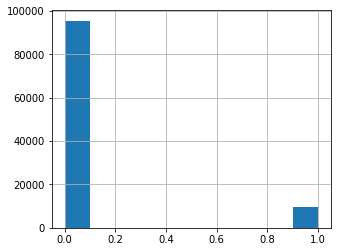

In [ ]:
df['loan_status'].hist()

In [ ]:
class_0 = df[df['loan_status'] == 0]
class_1 = df[df['loan_status'] == 1]
class_1.shape,class_0.shape

((9777, 761), (95517, 761))

Оставим 9 642 случайных записи из датафрейма с дефолтом по кредиту

In [ ]:
class_0_under = class_0.sample(class_1.shape[0])

df_under = pd.concat([class_0_under, class_1], axis=0)

print("total class of 1 and0:\n",df_under['loan_status'].value_counts())

total class of 1 and0:
 1    9777
0    9777
Name: loan_status, dtype: int64


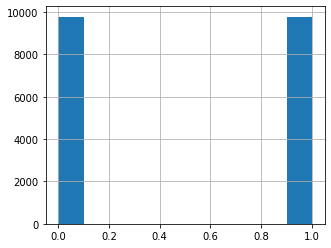

In [ ]:
df_under['loan_status'].hist()

## Train-test-split + Scaling + Feature selection

Проделаем те же манипуляции по подготовке данных

In [ ]:
# splitting
x_train_u, x_test_u, y_train_u, y_test_u = train_test_split(df_under.iloc[:,1:-2],df_under.iloc[:,-1],test_size=0.3)

#normalizing
normalizer = Normalizer()
x_train_u = pd.DataFrame(normalizer.fit_transform(x_train_u),columns=x_train_u.columns)
x_test_u = pd.DataFrame(normalizer.transform(x_test_u),columns=x_train_u.columns)

In [ ]:
# feature selection
selection_u = SelectPercentile(f_classif,10)
selection_u.fit_transform(x_train_u, y_train_u)

chosen_clms_u = selection_u.get_support(indices=True)
clm_names_u = x_train_u.iloc[:,chosen_clms_u].columns.values
clm_names_u

array(['f93', 'f113', 'f123', 'f162', 'f206', 'f207', 'f232', 'f252',
       'f277', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296',
       'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304',
       'f305', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320',
       'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328',
       'f332', 'f333', 'f334', 'f346', 'f347', 'f355', 'f364', 'f372',
       'f384', 'f390', 'f392', 'f422', 'f432', 'f530', 'f537', 'f541',
       'f551', 'f561', 'f571', 'f580', 'f626', 'f628', 'f660', 'f687',
       'f704', 'f705', 'f709', 'f719', 'f720', 'f721', 'f747', 'f749',
       'f752', 'f758', 'f762', 'f765'], dtype=object)

In [ ]:
x_train_u_76 = x_train_u.iloc[:,chosen_clms_u].copy()
x_test_u_76 = x_test_u.iloc[:,chosen_clms_u].copy()
x_train_u_76.shape

(13687, 76)

В итоге получили 76 признаков

## Random forest

Начнем искать идеальную комбинацию гиперпараметров

In [ ]:
param_grid_u = { 
    'n_estimators': [5, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,6,7,8],
    'criterion' :['gini', 'entropy']
}
model_u = RandomForestClassifier()

In [ ]:
CV_rfc_u = GridSearchCV(estimator=model_u, param_grid=param_grid_u, cv= 5,scoring='f1')
CV_rfc_u.fit(x_train_u_76, y_train_u)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
CV_rfc_u.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 5}

In [ ]:
model_u = RandomForestClassifier(n_estimators = 5,max_features='auto',max_depth=5,criterion='entropy')
model_u.fit(x_train_u_76, y_train_u)

model_u_pred = model_u.predict(x_test_u_76)

In [ ]:
model_u.feature_importances_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
f1_score(y_true = y_test_u,y_pred=model_u_pred)

0.06142903330100225

In [ ]:
roc_auc_score(y_test_u, model_u.predict_proba(x_test_u_76)[:,1])

0.5022607605321843



---


Видимо, признаки попались нехорошие.

Построим лес со всеми изначальными признаками

In [ ]:
model_u = RandomForestClassifier(n_estimators = 30,max_features='auto',max_depth=5,criterion='gini')
model_u.fit(x_train_u, y_train_u)

model_u_pred = model_u.predict(x_test_u)

In [ ]:
f1_score(y_true = y_test_u,y_pred=model_u_pred)

0.5533536585365854

In [ ]:
roc_auc_score(y_test_u, model_u.predict_proba(x_test_u)[:,1])

0.5045991477335453

Воспользуемся информацией от самого леса насчет лучших признаков и задействуем их

In [ ]:
model_u.feature_importances_.nonzero()

(array([383, 462, 525, 612]),)

In [ ]:
x_train_u.iloc[:,[383, 462, 525, 612]]

,f391,f472,f537,f627
0,0.489636,1.474244e-18,4.290814e-13,0.871927
1,0.582451,8.961897e-15,4.897469e-15,0.812866
2,0.608643,1.801517e-10,6.343064e-09,0.793444
3,0.616748,1.011913e-12,1.606810e-14,0.787161
4,0.587310,1.379869e-12,2.027257e-15,0.809362
...,...,...,...,...
13493,0.499183,1.684594e-07,2.224862e-10,0.866496
13494,0.566642,3.326952e-10,1.059737e-18,0.823964
13495,0.648893,1.261061e-03,8.954618e-04,0.760878
13496,0.678441,4.451057e-15,1.597397e-19,0.734655


Проведем поиск гиперпараметров

In [ ]:
model = RandomForestClassifier()
param_grid_u = { 
    'n_estimators': [5, 50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,3,4,5,6],
    'criterion' :['gini', 'entropy']
}
CV_rfc_u = GridSearchCV(estimator=model_u, param_grid=param_grid_u, cv= 5,scoring='f1')
CV_rfc_u.fit(x_train_u.iloc[:,[383, 462, 525, 612]], y_train_u)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=30, n_jobs=None,
                                              oob_score=False,
                                              random_st

In [ ]:
CV_rfc_u.best_params_

{'criterion': 'entropy',
 'max_depth': 2,
 'max_features': 'auto',
 'n_estimators': 5}

In [ ]:
model_u = RandomForestClassifier(n_estimators = 5,max_features='auto',max_depth=2,criterion='entropy')
model_u.fit(x_train_u.iloc[:,[383, 462, 525, 612]], y_train_u)

model_u_pred = model_u.predict(x_test_u.iloc[:,[383, 462, 525, 612]])

In [ ]:
f1_score(y_true = y_test_u,y_pred=model_u_pred)

0.6265748798545265

In [ ]:
roc_auc_score(y_test_u, model_u.predict_proba(x_test_u.iloc[:,[383, 462, 525, 612]])[:,1])

0.5125873930349399

## Логистическая регрессия

Воспользуемся еще одним алгоритмом для задачи классификации. Построим модель на 4х ранее выделенных признаках

In [ ]:
logreg = LogisticRegression().fit(x_train_u.iloc[:,[383, 462, 525, 612]], y_train_u)
logreg_pred = logreg.predict(x_test_u.iloc[:,[383, 462, 525, 612]])

In [ ]:
f1_score(y_test_u,logreg_pred)

0.590286784839314

In [ ]:
roc_auc_score(y_test_u, logreg.predict_proba(x_test_u.iloc[:,[383, 462, 525, 612]])[:,1])

0.504128884772152

Проверим и построим на всех данных

In [ ]:
logreg = LogisticRegression().fit(x_train_u, y_train_u)
logreg_pred = logreg.predict(x_test_u)
f1_score(y_test_u,logreg_pred)

0.5534988713318284

In [ ]:
roc_auc_score(y_test_u, logreg.predict_proba(x_test_u)[:,1])

0.49273016946552645

Проведем отбор гиперпараметров

In [ ]:
grid_values = {'penalty': ['l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
logreg = LogisticRegression()

logreg = GridSearchCV(logreg, param_grid=grid_values)
logreg.fit(x_train_u,y_train_u)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
logreg.best_params_

{'C': 1000, 'penalty': 'l2'}

In [ ]:
logreg = LogisticRegression(C=1000)
logreg.fit(x_train_u,y_train_u)
logreg_pred = logreg.predict(x_test_u)

In [ ]:
f1_score(y_test_u,logreg_pred)

0.5535797123859595

In [ ]:
roc_auc_score(y_test_u, logreg.predict_proba(x_test_u)[:,1])

0.5100101707617365

# Итоги

In [ ]:
lgd = [0.59028,0.50412,0.55357,0.51001]
rfg = [0.62657,0.51258,0.55335,0.50459]

res = pd.DataFrame([lgd,rfg],
                   columns=[['4_feats','4_feats','All','All'],['4_feats_F1','4_feats_RocAuc','All_F1','All_RocAuc'],],
                   index=['LogReg','RF']).T
res

LogReg       RF
4_feats 4_feats_F1      0.59028  0.62657
        4_feats_RocAuc  0.50412  0.51258
All     All_F1          0.55357  0.55335
        All_RocAuc      0.51001  0.50459

Как видно из таблицы, случайный лес выигрывает практически по всем показателям (не считая для всех значений).

Несмотря на то, что прирост довольно маленький, все значения выше 0.5

Можно сказать, что несбалансированный датасет в данном случае сильно повлиял на ход работы; подобный датасет в будущем можно попробовать undersample`ить с помощью функций от https://imbalanced-learn.org/stable/under_sampling.html 

К тому же, из-за количества признаков следовало отбирать их отдельно, для чего в дальнейшем можно попробовать использовать другие методы.

In [ ]:
%%shell
jupyter nbconvert --to html /content/Koshkareva_FinProject.ipynb

[NbConvertApp] Converting notebook /content/Koshkareva_FinProject.ipynb to html
[NbConvertApp] Writing 480390 bytes to /content/Koshkareva_FinProject.html
